## Perspective PS2 

### 1. Income data, lognormal distribution and hypothesis testing 

#### a). plot a histogram 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model as skl
import scipy.stats as sts

<IPython.core.display.Javascript object>


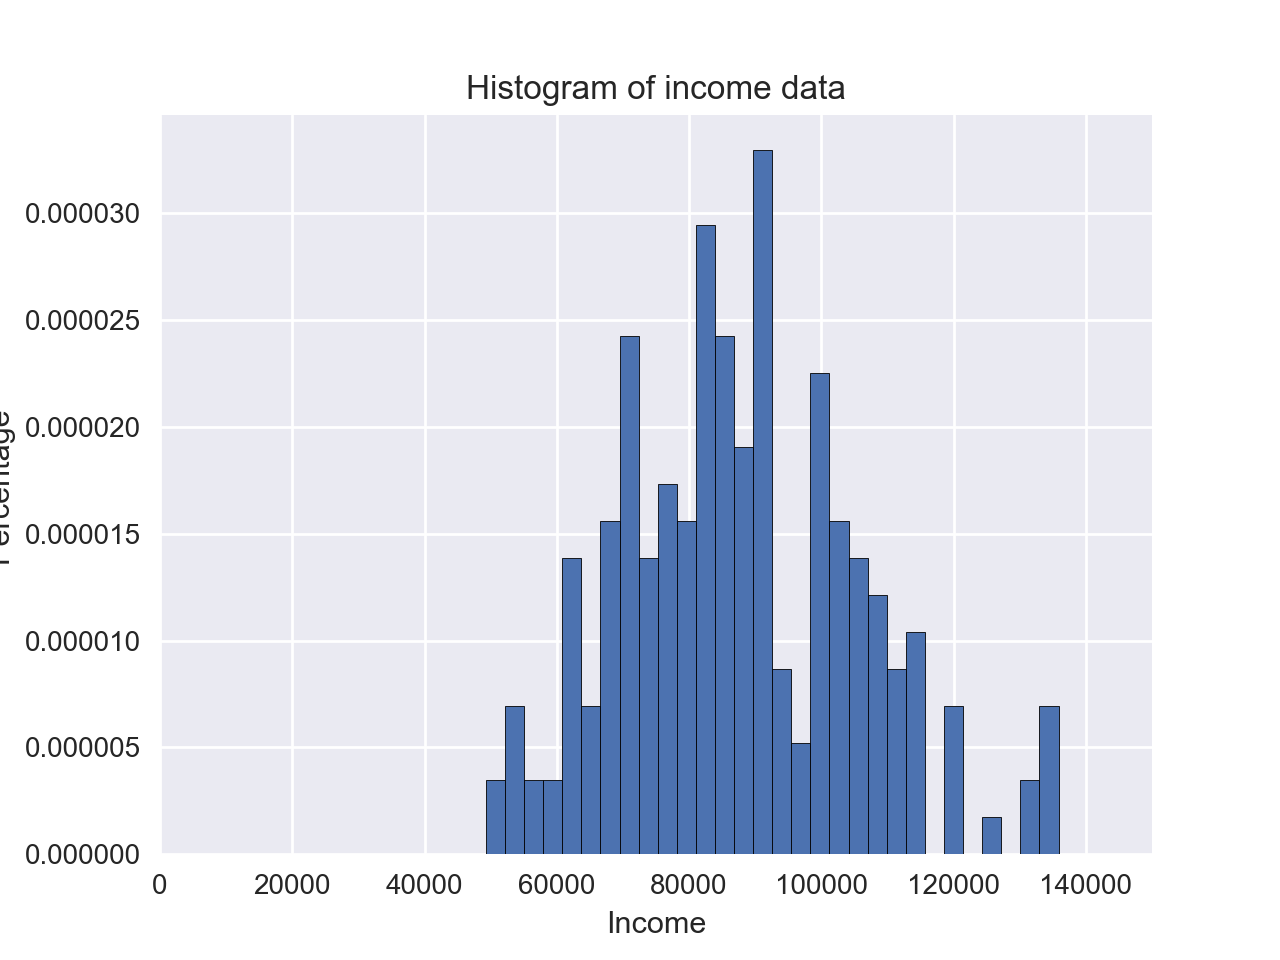

(0, 150000)

In [15]:
income = np.array(pd.read_csv('incomes.txt', header=None))
sns.set(style="darkgrid")

%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Histogram of income data')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xlim([0, 150000])

#### b). plot lognormal pdf

<IPython.core.display.Javascript object>


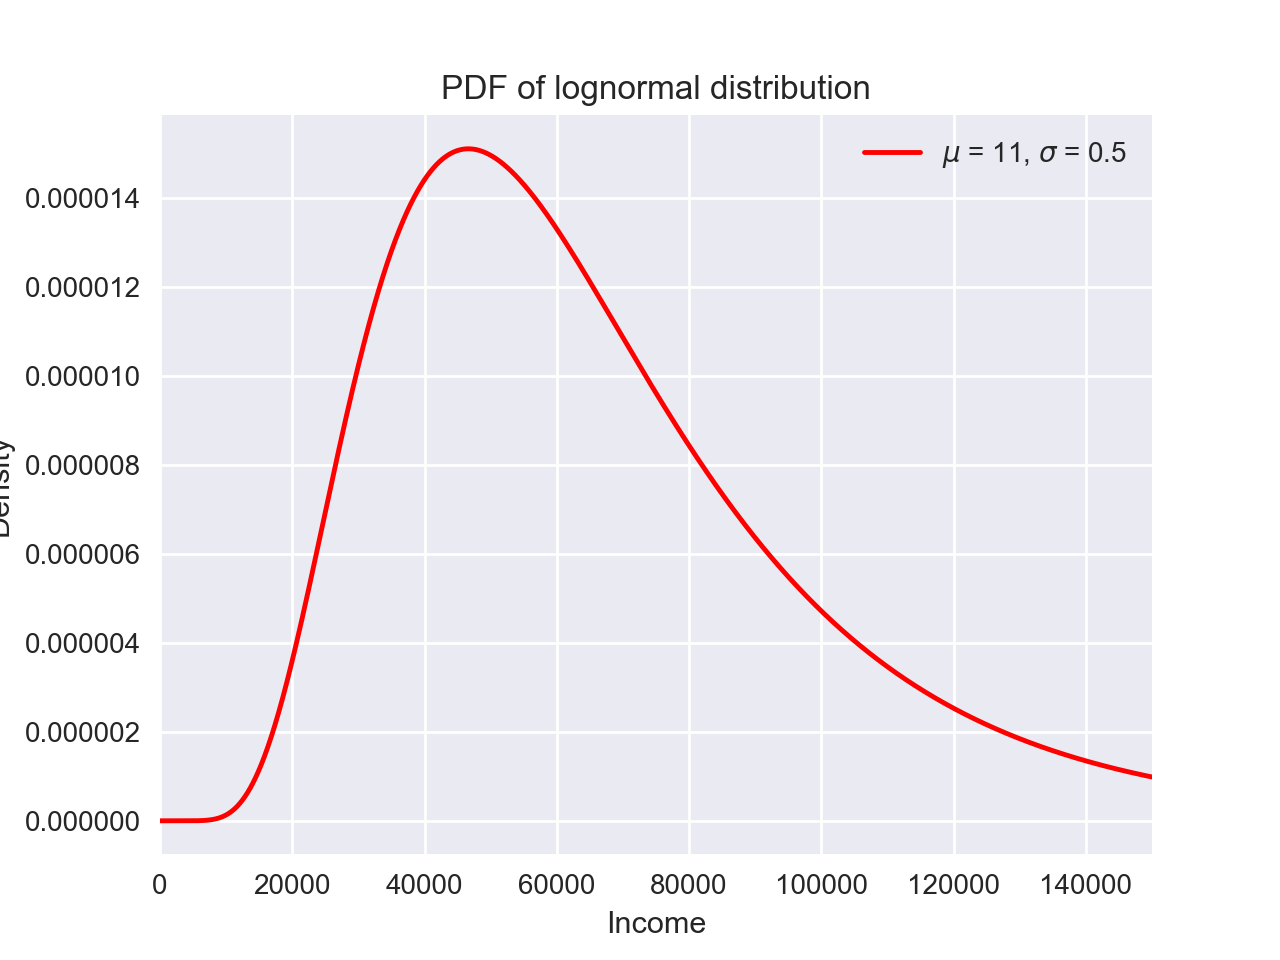

In [16]:
mu, sigma = 11.0, 0.5
xvals = np.linspace(0.00001, 150000, 10000) # set as 0.00001 to avoid dividing by 0

def lognormal_pdf(xvals, mu, sigma):
    return  (1/(xvals * sigma * np.sqrt(2 * np.pi)) * np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma ** 2)))

%matplotlib notebook
plt.plot(xvals, lognormal_pdf(xvals, mu, sigma),'r-', label = '$\mu$ = 11, $\sigma$ = 0.5')
plt.title('PDF of lognormal distribution')
plt.xlabel('Income')
plt.ylabel('Density')
plt.xlim([0, 150000])
plt.legend()
    

#### compute the log-likelihood function given the data

In [4]:
# Define log likelihood function for log normal distribution
def log_lik(xvals, mu, sigma):
    
    pdf_vals = lognormal_pdf(xvals, mu, sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

log_lik_h0 = log_lik(income, mu, sigma)
log_lik_h0

-2385.8569978085579

#### c). estimate the parameters of lognormal distribution by MLE

In [5]:
# Define the criterion function as the loglikelihood function
def crit(params, *args):
    mu, sigma = params
    xvals, = args
    log_lik_val = log_lik(xvals, mu, sigma)
    neg_log_lik_val = -log_lik_val    
    return neg_log_lik_val

In [6]:
# minimize the criterion function 
import scipy.optimize as opt
mu_init = 11.0 
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
mle_args = (income, )
results = opt.minimize(crit, params_init, args= mle_args, method = 'L-BFGS-B',
                       bounds=((1e-10, None), (0.1, None)))

In [7]:
mu_MLE, sig_MLE = results.x
print('mu_MLE =', mu_MLE, ' sig_MLE =', sig_MLE)
log_lik_MLE = log_lik(income, mu_MLE, sig_MLE)
print('the value of log likelihood function =', log_lik_MLE)

OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) =', vcv_mle)

mu_MLE = 11.3590244074  sig_MLE = 0.208178536649
the value of log likelihood function = -2241.71930137
VCV(MLE) = [[  2.52839841e-04  -2.76204011e-05]
 [ -2.76204011e-05   1.30454204e-04]]


<IPython.core.display.Javascript object>


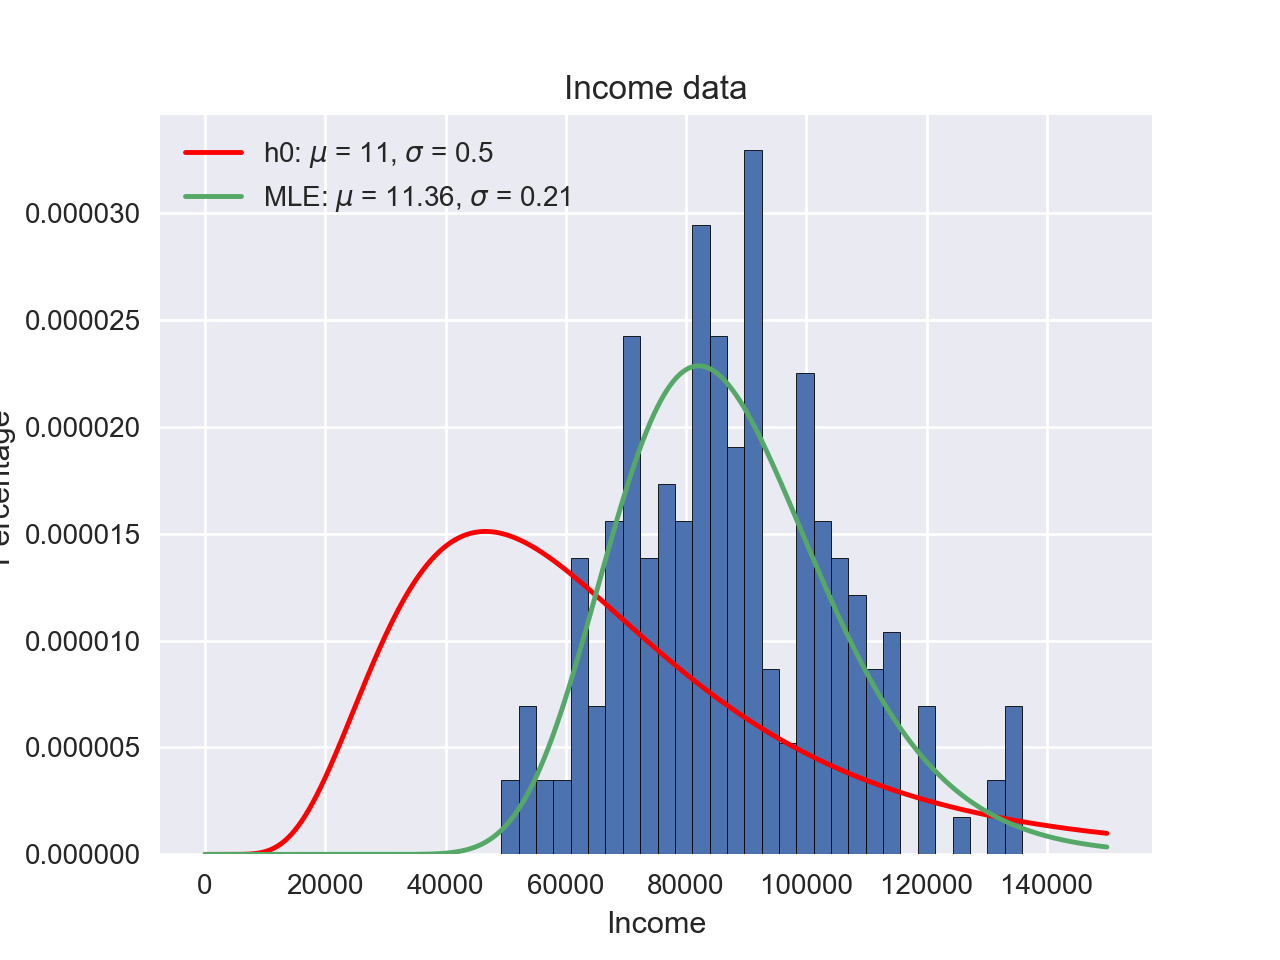

In [8]:
# plot the graph
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.plot(xvals, lognormal_pdf(xvals, mu, sigma),'r-', label = 'h0: $\mu$ = 11, $\sigma$ = 0.5')
plt.plot(xvals, lognormal_pdf(xvals, mu_MLE, sig_MLE), label = 'MLE: $\mu$ = 11.36, $\sigma$ = 0.21')
plt.title('Income data')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.legend()

#### d). perform likelihood ratio test 

In [9]:
# log likelihood for the hypothesized parameter value 
log_lik_h0 = log_lik(income, mu, sigma)
# log likelihood under MLE 
log_lik_mle = log_lik(income, mu_MLE, sig_MLE)
# compute the likelihood ratio 
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


Since p-values = 0.0, we reject the null hypothesis.

#### e). estimate the probability

In [10]:
# define the cdf for lognormal distribution 
def lognormal_cdf(x, mu, sigma):
    x_trans = (np.log(x) - mu)/sigma
    cdf = sts.norm.cdf(x_trans)
    return cdf 

# probability of earning more than $100,000
p_100000 = 1 - lognormal_cdf(100000, mu_MLE, sig_MLE)
print('probability of earning more than $100,000: ', p_100000)

# probability of earning less than $75,000
p_75000 = lognormal_cdf(75000, mu_MLE, sig_MLE)
print('probability of earning less than $75,000: ', p_75000)


probability of earning more than $100,000:  0.229870203058
probability of earning less than $75,000:  0.260233287857


### 2. Linear regression and MLE 

#### a). estimate the paramters 

In [11]:
# linear regression
# sick = beta0 + beta1*age + beta2*children + beta3*temp_winter + epsilon 
sick_dta = pd.read_csv('sick.txt', sep=",", header=0)
n = sick_dta.shape[0]

In [12]:
# define the error term 
def error_term(params, dta):
    (b0, b1, b2, b3, sigma) = params
    sick, age, children, temp_winter = dta
    error = np.sum((sick - b0 - b1*age - b2*children - b3*temp_winter)**2)
    return error

# define the criterion function
def crit2(params, *args):
    (b0, b1, b2, b3, sigma) = params
    sick, age, children, temp_winter = args    
    log_lik_val = (-n/2 * np.log(2 * np.pi)- n * np.log(sigma)-1/(2 * sigma**2) * 
                   error_term(params,(sick, age, children, temp_winter)))
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

In [13]:
# maximize the log-likelihood function
b0_int = 0
b1_int = 0
b2_int = 0
b3_int = 0
sig_int = 1      
params_init = np.array([b0_int, b1_int, b2_int, b3_int, sig_int])
args_mle = (sick_dta.sick, sick_dta.age, sick_dta.children, sick_dta.avgtemp_winter)

res = opt.minimize(crit2, params_init, args= (args_mle), method = 'L-BFGS-B',
                       bounds=((None, None), (None, None),(None, None),(None, None),
                               (0.00001, None)))

b0_MLE, b1_MLE, b2_MLE, b3_MLE, sig_MLE = res.x
print('b0_MLE, b1_MLE, b2_MLE, b3_MLE, sigma_MLE = ',
     b0_MLE,',',b1_MLE,',', b2_MLE,',', b3_MLE,',', sig_MLE)
print('the value of log likelihood function =', res.fun)

OffDiagNeg = np.identity(5)*2. - np.ones((5,5))
#print(OffDiagNeg)
vcv_mle = res.hess_inv.todense() * OffDiagNeg
print('VCV(MLE) =', vcv_mle)

b0_MLE, b1_MLE, b2_MLE, b3_MLE, sigma_MLE =  0.251644668852 , 0.0129334502367 , 0.400501200357 , -0.00999169405505 , 0.00301768848237
the value of log likelihood function = -876.86506404
VCV(MLE) = [[  2.70656083e+03  -1.68129147e+02   1.74328552e+03   1.49648096e+02
    1.32674974e+01]
 [ -1.68129147e+02   1.04440492e+01   1.08291442e+02   9.29601514e+00
    8.24308663e-01]
 [  1.74328552e+03   1.08291442e+02   1.12284417e+03  -9.63878211e+01
   -8.54641326e+00]
 [  1.49648096e+02   9.29601514e+00  -9.63878211e+01   8.27417772e+00
   -7.33648365e-01]
 [  1.32674974e+01   8.24308663e-01  -8.54641326e+00  -7.33648365e-01
    6.62916716e-02]]


#### b). hypothesis test

In [14]:
# log likelihood for the hypothesized parameter value 
params = (1, 0, 0, 0, 0.01)
sigma = params[4]
dta = sick_dta.sick, sick_dta.age, sick_dta.children, sick_dta.avgtemp_winter
log_lik_h0 = (-n/2 * np.log(2 * np.pi)- n * np.log(sigma)-1/(2 * sigma**2) * 
                   error_term(params, dta))
# log likelihood under MLE 
params_mle = res.x
sig_mle = params[4]
log_lik_mle = (-n/2 * np.log(2 * np.pi)- n * np.log(sig_mle)-1/(2 * sig_mle**2) * 
                   error_term(params_mle,dta))
# compute the likelihood ratio 
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 5) 
print('chi squared of H0 with 5 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 5 degrees of freedom p-value =  0.0


According to the result, the likelihood that age, number of children and average winter tempature have no effect on the number of sick days is 0.0.